In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

***Projected Subgradient Method***

In [5]:
def read_data(verbose=False):

    data = pd.read_csv("all_stocks_5yr.csv")
    df = data[["date", "Name", "close"]]

    prices = df.pivot(index="date", columns="Name", values="close")
    prices = prices.dropna(axis=1)

    # with open("prices.txt", "w") as f:
    #     f.write(prices.to_string())
    #     f.close()

    returns = prices.pct_change().dropna()
    # with open("rendements.txt", "w") as f:
    #     f.write(returns.to_string())
    #     f.close()


    X = returns.values
    mu = returns.mean().values
    Sigma = returns.cov().values


    if verbose:
        print("X shape =", X.shape)
        print("mu shape =", mu.shape)
        print("Sigma shape =", Sigma.shape)
    
    return X, mu, Sigma



In [93]:
def projection_on_simplex(v):
    """
    Project a vector v onto the simplex:
        Δ = { w >= 0, sum(w) = 1 }
    """
   
    u = sorted(v, reverse=True)
    cumulative_sum = np.cumsum(u)

    thetas = (cumulative_sum - 1) / (np.arange(1, len(v) + 1))
    k = np.where(u - thetas > 0)[0].max()

    theta = (cumulative_sum[k] - 1) / (k + 1)
    w = np.maximum(v - theta, 0)

    return w

def test(): 
    v = np.array([0.9, 0.9, 0.2])
    v2 = -1 * v

    print("w1 : ", projection_on_simplex(v))
    print("w2 : ", projection_on_simplex(v2))

#test()

def sign(v):
    result = np.zeros_like(v)

    result[v > 0] = 1
    result[v < 0] = -1

    return result


def obj_f_nonSmooth(w, wprev, Sigma, mu, lam, c):

    return 0.5 * w.T @ Sigma @ w -lam * (mu @ w) + \
            c * np.sum(np.abs(w - wprev))

def projected_subgradient_method(lam, c, Sigma, mu, wprev, alpha0=0.1, max_iter=50000, tol= 1e-8, plot=False): 

    w = wprev
    k = 0
    if plot:
        obj_values = []
    for k in tqdm(range(max_iter)):

        if plot:
            obj_values.append(obj_f_nonSmooth(w, wprev, Sigma, mu, lam, c))

        g = Sigma @ w - lam * mu + c * np.sign(w - wprev)
        step_size = alpha0 / (k + 1)
        w_new = projection_on_simplex(w - step_size * g)
        
        if (np.linalg.norm(w_new - w) < tol):
            print(f"Converged in {k} iterations.")
            break

        w = w_new

    with open("values.txt", "w") as f:
        f.write(str(obj_values))
        f.close()


    if plot:
        plt.plot(obj_values)
        plt.xlabel("Iteration")
        
       # plt.yscale("log")
        plt.ylabel("Objective value (log scale)")
        plt.title("Convergence of Projected Subgradient Method")
        plt.show()
    
    return w




    

X shape = (1258, 470)
mu shape = (470,)
Sigma shape = (470, 470)


 19%|█▊        | 9312/50000 [00:03<00:13, 2924.73it/s]


Converged in 9312 iterations.


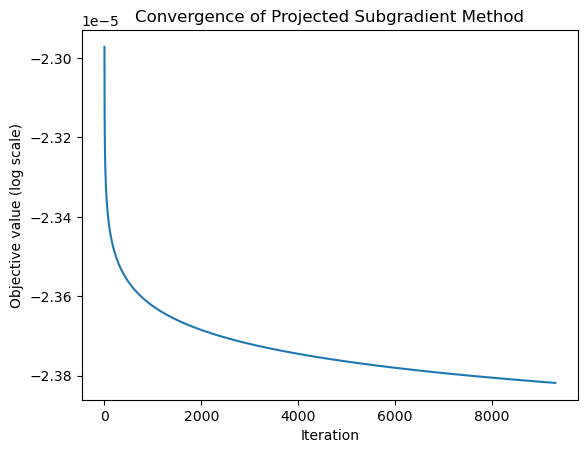

Optimal weights: [0.00210821 0.00217068 0.00212138 0.00216147 0.00217408 0.00215384
 0.00212537 0.00214125 0.00220167 0.00212455 0.00211082 0.00213267
 0.00211457 0.00215057 0.00214655 0.00213907 0.00208063 0.002186
 0.00212788 0.00213945 0.00211151 0.00212627 0.00215228 0.00213238
 0.00212624 0.00212125 0.00223426 0.00215265 0.00215262 0.00209672
 0.00217003 0.00222166 0.00212159 0.00207177 0.00213135 0.00212497
 0.00213982 0.00221763 0.00212766 0.00213736 0.00219012 0.00215693
 0.00216998 0.00201568 0.00203861 0.00212766 0.0021502  0.00213641
 0.00206986 0.00221419 0.0021223  0.00221848 0.00216332 0.00216498
 0.00211859 0.00213719 0.00214788 0.00219841 0.00214003 0.00210593
 0.00212291 0.00221485 0.00216508 0.00204716 0.00214852 0.002132
 0.00212474 0.00212366 0.00213078 0.00213913 0.00218123 0.00209263
 0.00210067 0.00210515 0.00210797 0.00211326 0.00211684 0.00211465
 0.00213105 0.00210611 0.00220184 0.00209782 0.00213604 0.00212766
 0.00216414 0.00212636 0.00211542 0.00208254 0.00

In [100]:
X, mu, Sigma = read_data(verbose=True)
lam = 0.1
c = 0.000001
wprev = np.ones(X.shape[1]) / X.shape[1]

w = projected_subgradient_method(lam, c, Sigma, mu, wprev, tol= 1e-8, plot=True)
print("Optimal weights:", w)
print("Sum of weights:", np.sum(w))
print("Converged objective value:", obj_f_nonSmooth(w, wprev, Sigma, mu, lam, c))

***Proximal gradient method***

In [ ]:
def prox(wprev, step_size, v, c):
    return wprev + sign(v - wprev) * np.maximum(np.abs(v - wprev) - c * step_size, 0)


def proximal_gradient_method(lam, c, Sigma, mu, wprev, L, max_iter=50000, tol= 1e-8, plot=False): 

    w = wprev
    step_size = 1/L
    if plot:
        obj_values = []
    for k in tqdm(range(max_iter)):

        if plot:
            obj_values.append(obj_f_nonSmooth(w, wprev, Sigma, mu, lam, c))

        v = w - step_size * (Sigma @ w - lam * mu)
        u = prox(wprev, step_size, v, c)
        w_new = projection_on_simplex(u)
        # if k == 0:
        #     print("norm(v-w):", np.linalg.norm(v - w))
        #     print("c/L:", c / L)
        #     print("max(|v-w|):", np.max(np.abs(v - w)))
        
        if (np.linalg.norm(w_new - w) < tol) and k > -1000:
            print(f"Converged in {k} iterations.")
            break

        w = w_new

    with open("values_proximal.txt", "w") as f:
        f.write(str(obj_values))
        f.close()


    if plot:
        plt.plot(obj_values)
        plt.xlabel("Iteration")
        
        #plt.yscale("log")
        #plt.yscale('symlog', linthresh=1e-3)
        plt.ylabel("Objective value (log scale)")
        plt.title("Convergence of Proximal Gradient Method")
        plt.show()
    
    return w

    

  1%|          | 580/50000 [00:00<00:17, 2754.89it/s]

norm(v-w): 0.029605447556339634
c/L: 3.054817718645066e-05
max(|v-w|): 0.006091384258116098


 10%|▉         | 4928/50000 [00:01<00:16, 2702.74it/s]


Converged in 4928 iterations.


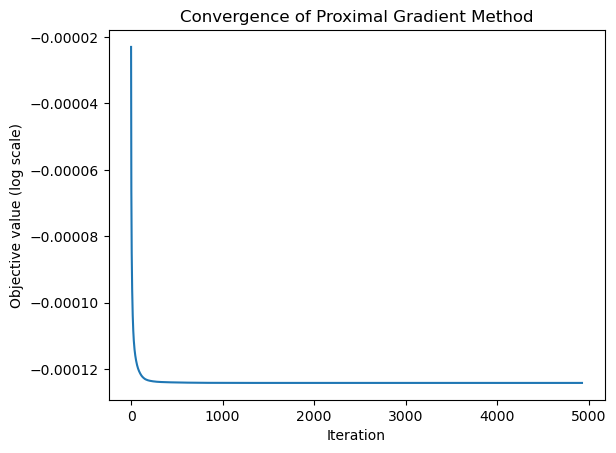

Optimal weights: [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.07153961e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.06833041e-02 0.00000000e+00 0.00000000e+00
 0.0000

In [99]:
#X, mu, Sigma = read_data(verbose=True)
lam = 0.1
c = 0.000001
L = np.linalg.eigvalsh(Sigma).max()
wprev = np.ones(X.shape[1]) / X.shape[1]

w = proximal_gradient_method(lam, c, Sigma, mu, wprev, L, max_iter=50000, tol= 1e-8, plot=True) 
print("Optimal weights:", w)
print("Sum of weights:", np.sum(w))
print("Converged objective value:", obj_f_nonSmooth(w, wprev, Sigma, mu, lam, c))